Value at Risk (95%) - Historical Simulation: 0.6241
Value at Risk (95%) - Variance-Covariance: 0.7110


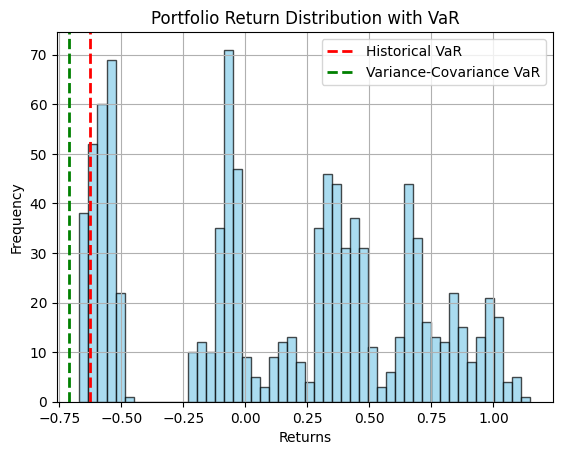

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load data
data = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)

# Convert 'Adj Close' column to numeric, handling errors
data['Adj Close'] = pd.to_numeric(data['Adj Close'], errors='coerce')

# Calculate daily returns
returns = data['Adj Close'].pct_change().dropna()

# Portfolio weights (equal weights example)
# Since we're using only 'Adj Close', weights are 1
weights = np.array([1])

# Confidence level
confidence_level = 0.95
z_score = norm.ppf(1 - confidence_level)

# 1. Historical Simulation VaR
portfolio_returns = returns
 # This will simply be returns
historical_var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

# 2. Variance-Covariance VaR
portfolio_mean = np.mean(portfolio_returns)
portfolio_std = np.std(portfolio_returns)
varcovar_var = -(portfolio_mean + z_score * portfolio_std)

# Display results
print(f"Value at Risk (95%) - Historical Simulation: {historical_var:.4f}")
print(f"Value at Risk (95%) - Variance-Covariance: {varcovar_var:.4f}")

plt.hist(portfolio_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(-historical_var, color='red', linestyle='dashed', linewidth=2, label='Historical VaR')
plt.axvline(-varcovar_var, color='green', linestyle='dashed', linewidth=2, label='Variance-Covariance VaR')
plt.legend()
plt.title("Portfolio Return Distribution with VaR")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

def calculate_var(returns_data, weights=None, confidence_level=0.95, investment_value=100000, time_horizon=1):
    """
    Calculate Value at Risk using multiple methods

    Parameters:
    -----------
    returns_data : DataFrame
        DataFrame containing asset returns
    weights : array-like, optional
        Portfolio weights for each asset. If None, equal weights are used
    confidence_level : float, default 0.95
        Confidence level for VaR calculation
    investment_value : float, default 100000
        Total investment value of the portfolio
    time_horizon : int, default 1
        Time horizon in days for scaling VaR

    Returns:
    --------
    dict : Dictionary containing VaR results and portfolio returns
    """
    # If no weights provided, use equal weights
    if weights is None:
        weights = np.ones(len(returns_data.columns)) / len(returns_data.columns)

    # Ensure weights sum to 1
    weights = np.array(weights) / sum(weights)

    # Calculate portfolio returns
    portfolio_returns = returns_data.dot(weights)

    # Make sure we have enough data points
    if len(portfolio_returns) < 2:
        raise ValueError("Not enough return data points to calculate VaR")

    # 1. Historical Simulation VaR
    historical_var = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)

    # 2. Parametric (Variance-Covariance) VaR
    z_score = norm.ppf(1 - confidence_level)
    portfolio_mean = np.mean(portfolio_returns)
    portfolio_std = np.std(portfolio_returns)
    parametric_var = -(portfolio_mean + z_score * portfolio_std)

    # 3. Monte Carlo Simulation VaR
    try:
        # Assuming returns follow a multivariate normal distribution
        mean_returns = returns_data.mean().values
        cov_matrix = returns_data.cov().values

        # Generate random returns
        np.random.seed(42)
        num_simulations = 10000

        # Handle single asset case differently
        if len(returns_data.columns) == 1:
            simulated_returns = np.random.normal(
                mean_returns[0],
                np.sqrt(cov_matrix[0][0]),
                num_simulations
            ).reshape(-1, 1)
            simulated_portfolio_returns = simulated_returns.flatten()
        else:
            simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, num_simulations)
            simulated_portfolio_returns = np.dot(simulated_returns, weights)

        monte_carlo_var = -np.percentile(simulated_portfolio_returns, (1 - confidence_level) * 100)
    except Exception as e:
        print(f"Warning: Could not calculate Monte Carlo VaR: {e}")
        monte_carlo_var = np.nan

    # Scale VaR to investment value and time horizon
    scale_factor = np.sqrt(time_horizon)
    historical_var_value = historical_var * investment_value * scale_factor
    parametric_var_value = parametric_var * investment_value * scale_factor
    monte_carlo_var_value = monte_carlo_var * investment_value * scale_factor

    return {
        'portfolio_returns': portfolio_returns,
        'historical_var': historical_var,
        'parametric_var': parametric_var,
        'monte_carlo_var': monte_carlo_var,
        'historical_var_value': historical_var_value,
        'parametric_var_value': parametric_var_value,
        'monte_carlo_var_value': monte_carlo_var_value,
        'confidence_level': confidence_level,
        'investment_value': investment_value,
        'time_horizon': time_horizon
    }

def plot_var_results(var_results):
    """
    Create visualizations for VaR analysis
    """
    portfolio_returns = var_results['portfolio_returns']

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # 1. Returns distribution with VaR lines
    sns.histplot(portfolio_returns, kde=True, ax=ax1, color='skyblue', stat='density')

    # Add VaR lines
    methods = ['historical_var', 'parametric_var', 'monte_carlo_var']
    colors = ['red', 'green', 'purple']
    labels = ['Historical', 'Parametric', 'Monte Carlo']

    for method, color, label in zip(methods, colors, labels):
        if not np.isnan(var_results[method]):
            ax1.axvline(-var_results[method], color=color, linestyle='dashed',
                      linewidth=2, label=f'{label} VaR ({var_results["confidence_level"]*100:.0f}%)')

    ax1.set_title('Portfolio Return Distribution with VaR', fontsize=14)
    ax1.set_xlabel('Returns', fontsize=12)
    ax1.set_ylabel('Density', fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. VaR comparison bar chart
    # Only include methods that have valid results
    valid_methods = []
    valid_values = []
    valid_colors = []

    var_methods = ['Historical', 'Parametric', 'Monte Carlo']
    var_value_keys = ['historical_var_value', 'parametric_var_value', 'monte_carlo_var_value']
    colors = ['red', 'green', 'purple']

    for method, value_key, color in zip(var_methods, var_value_keys, colors):
        if value_key in var_results and not np.isnan(var_results[value_key]):
            valid_methods.append(method)
            valid_values.append(var_results[value_key])
            valid_colors.append(color)

    if valid_methods:
        bars = ax2.bar(valid_methods, valid_values, color=valid_colors, alpha=0.7)

        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax2.annotate(f'${height:,.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=11)
    else:
        ax2.text(0.5, 0.5, "No valid VaR values to display",
                horizontalalignment='center', verticalalignment='center',
                transform=ax2.transAxes, fontsize=14)

    ax2.set_title(f'Value at Risk Comparison (${var_results["investment_value"]:,.0f} investment, {var_results["time_horizon"]} day horizon)',
                 fontsize=14)
    ax2.set_ylabel('VaR ($)', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    return fig

def main():
    try:
        print("Starting VaR analysis...")

        # Load data
        print("Loading stock data from CSV...")
        try:
            data = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)
            print(f"Data loaded: {data.shape[0]} rows, {data.shape[1]} columns")
            print(f"Columns: {data.columns.tolist()}")
            print(f"First few rows:\n{data.head()}")
        except Exception as e:
            print(f"Error loading data: {e}")
            return

        # Convert all columns to numeric
        print("Converting data to numeric values...")
        for column in data.columns:
            data[column] = pd.to_numeric(data[column], errors='coerce')

        # Drop any rows with NaN values to ensure clean data
        orig_len = len(data)
        data = data.dropna()
        print(f"Dropped {orig_len - len(data)} rows with NaN values, {len(data)} rows remaining")

        # Make sure we have data to work with
        if data.empty:
            print("Error: No valid data found after cleaning. Please check your CSV file.")
            return

        # Check if data has multiple assets or just a single 'Adj Close' column
        print("Calculating returns...")
        if 'Adj Close' in data.columns and len(data.columns) == 1:
            # Calculate returns for single column
            returns = data['Adj Close'].pct_change(fill_method=None).dropna().to_frame()
            print("Working with single asset (Adj Close column)")
        else:
            # For multiple assets, calculate returns for each
            returns = data.pct_change(fill_method=None).dropna()
            print(f"Working with multiple assets: {len(returns.columns)} columns")

        print(f"Return calculation complete: {len(returns)} rows of returns")

        # Check if returns dataframe is empty
        if returns.empty or returns.shape[0] == 0:
            print("Error: Unable to calculate returns. Please check your data.")
            return

        # Parameters
        confidence_level = 0.95  # 95% confidence
        investment_value = 100000  # $100,000 portfolio
        time_horizon = 1  # 1-day VaR

        # Equal weights if multiple assets (making sure returns has columns)
        if len(returns.columns) > 0:
            weights = np.ones(len(returns.columns)) / len(returns.columns)
            print(f"Using equal weights for {len(returns.columns)} assets")
        else:
            print("Error: No columns found in returns dataframe")
            return

        # Calculate VaR
        print("Calculating VaR using multiple methods...")
        try:
            var_results = calculate_var(
                returns,
                weights=weights,
                confidence_level=confidence_level,
                investment_value=investment_value,
                time_horizon=time_horizon
            )
            print("VaR calculation complete")
        except Exception as e:
            print(f"Error calculating VaR: {e}")
            import traceback
            traceback.print_exc()
            return

        # Display results
        print(f"\nVaR Analysis Results (${investment_value:,.0f} portfolio, {confidence_level*100:.0f}% confidence):")
        print("-" * 70)
        for method_name, method_key in [
            ("Historical Simulation VaR", "historical_var"),
            ("Parametric VaR", "parametric_var"),
            ("Monte Carlo VaR", "monte_carlo_var")
        ]:
            if method_key in var_results and not np.isnan(var_results[method_key]):
                print(f"{method_name}: {var_results[method_key]:.4f} ({time_horizon}-day return)")
            else:
                print(f"{method_name}: Not available")

        print("-" * 70)
        print(f"In monetary terms (${investment_value:,.0f} portfolio):")
        for method_name, method_key in [
            ("Historical Simulation VaR", "historical_var_value"),
            ("Parametric VaR", "parametric_var_value"),
            ("Monte Carlo VaR", "monte_carlo_var_value")
        ]:
            if method_key in var_results and not np.isnan(var_results[method_key]):
                print(f"{method_name}: ${var_results[method_key]:,.2f}")
            else:
                print(f"{method_name}: Not available")

        # Plot results
        print("Creating visualization...")
        try:
            fig = plot_var_results(var_results)
            plt.show()
            print("Visualization complete")
        except Exception as e:
            print(f"Error creating visualization: {e}")

    except FileNotFoundError:
        print("Error: stock_data.csv file not found.")
    except Exception as e:
        print(f"An error occurred: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

Starting VaR analysis...
Loading stock data from CSV...
Data loaded: 972 rows, 7 columns
Columns: ['Ticker', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
First few rows:
                 Ticker    Adj Close        Close         High          Low  \
Date                                                                          
2023-07-03  HDFCBANK.NS  1696.631836  1719.800049  1757.500000  1710.000000   
2023-07-03      INFY.NS  1309.278564  1333.699951  1346.000000  1328.449951   
2023-07-03  RELIANCE.NS  2405.791992  2414.290283  2420.105225  2358.587158   
2023-07-03       TCS.NS  3216.993164  3272.300049  3318.800049  3268.750000   
2023-07-04  HDFCBANK.NS  1704.918579  1728.199951  1747.000000  1713.800049   

                   Open      Volume  
Date                                 
2023-07-03  1712.500000  22052058.0  
2023-07-03  1330.000000   7732412.0  
2023-07-03  2361.079346   6077193.0  
2023-07-03  3314.300049   1687264.0  
2023-07-04  1723.449951  19397594.0  
